In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')

import os
os.environ["LD_LIBRARY_PATH"]="/local/cuda-10.2/lib64"
sys.path.append("/local/cuda-10.2/bin")


import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import time
import threading
import gc
import copy
import pandas as pd

sys.path.append("/end/home/rh2310/morpho_repo/turing_codebase")
from turing.utils import *
import turing.pinns as tu
from turing.loss_functions import *
from turing.pinns_experimental import TINN_masked, TINN_multi_nodes_masked



# GPU = True
# import os

# if GPU:
#     txt_device = 'gpu:0'
# else:
#     txt_device = 'cpu:0'    
#     os.environ["CUDA_VISIBLE_DEVICES"]="-1"

2022-07-25 22:36:52.938674: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-07-25 22:37:04.272301: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-07-25 22:37:04.293518: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:2d:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2022-07-25 22:37:04.293557: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-07-25 22:37:04.296573: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2022-07-25 22:37:04.299511: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10

In [2]:
def plot_result(results, start=0, end=-1, node_names=["u", "v"], yscale="log", y_lims=None):
    import matplotlib.pyplot as plt

    def _closing_commands_():
        plt.legend()
        plt.grid()
        plt.xlabel("Iterations")
        plt.yscale(yscale)
        if y_lims is not None:
            plt.ylim(y_lims)
        plt.show()

    _ = plt.figure(figsize=(14, 5))
    plt.title("Training accuracy for observations")
    plt.plot(results["training_obs_accuracy"][start:end], label="accuracy")
    _closing_commands_()

    if np.any([True if k.startswith("loss_") else False for k in results.keys()]):
        _ = plt.figure(figsize=(14, 5))
        plt.title("Real Loss")
        plt.plot(results["loss_total"][start:end], label="total")
        for i, name in enumerate(node_names):
            plt.plot(results[f"loss_obs"][start:end, i], label=f"Obs {name}")
        for i, name in enumerate(node_names):
            plt.plot(results[f"loss_pde"][start:end, i], label=f"PDE {name}")
        for key in [k for k in results.keys() if k.startswith("loss_extra_")]:
            plt.plot(results[key][start:end], label=f"{key}")

        _closing_commands_()

    if np.any([True if k.startswith("loss_") else False for k in results.keys()]):
        _ = plt.figure(figsize=(14, 5))
        plt.title("Regularisd Loss")
        plt.plot(results["loss_regularisd_total"][start:end], label="total")
        if np.any([True if k.startswith("lambda_") else False for k in results.keys()]):
            for i, name in enumerate(node_names):
                plt.plot(
                    results[f"lambda_obs"][start:end, i] * results[f"loss_obs"][start:end, i],
                    label=f"Obs {name}",
                )
            for i, name in enumerate(node_names):
                plt.plot(
                    results[f"lambda_pde"][start:end, i] * results[f"loss_pde"][start:end, i],
                    label=f"PDE {name}",
                )
        _closing_commands_()

    if np.any([True if k.startswith("grads_") else False for k in results.keys()]):
        _ = plt.figure(figsize=(14, 5))
        plt.title("Gradient Norms")
        for i, name in enumerate(node_names):
            plt.plot(results[f"grads_obs"][start:end, i], label=f"Grad obs {name}")
        for i, name in enumerate(node_names):
            plt.plot(results[f"grads_pde"][start:end, i], label=f"Grad PDE {name}")
        _closing_commands_()

    if np.any([True if k.startswith("lambda_") else False for k in results.keys()]):
        _ = plt.figure(figsize=(14, 5))
        plt.title(r"$\lambda$s")
        for i, name in enumerate(node_names):
            plt.plot(results[f"lambda_obs"][start:end, i], label=r"$\lambda$" f" obs {name}")
        for i, name in enumerate(node_names):
            plt.plot(results[f"lambda_pde"][start:end, i], label=r"$\lambda$" f" PDE {name}")
        _closing_commands_()


In [3]:
df_params = pd.read_pickle("../../bacterialcolony_dataset/df_circuit2_variant5716gaussian_30000parametersets.pkl")

In [4]:
df_params.head()

,Va,Vb,Vc,Vd,Ve,Vf,ba,bb,bc,bd,...,kaa,kbd,kce,kda,keb,kee,kfe,mua,mulva,n
0,360.066204,69.840434,33.468912,283.316201,79.328098,35.847305,0.007714,0.009772,0.010261,0.008996,...,2.316063,2.874391,88.732068,9.363779,9.627162,0.275728,5.519184,4.664757,1.485684,2.0
1,271.955874,101.868916,28.546540,347.711607,84.727223,41.786928,0.008341,0.012020,0.013054,0.010064,...,4.883066,3.640181,99.577576,9.439324,7.552942,0.252092,4.607892,2.973656,1.423090,2.0
2,310.495835,79.551016,51.789526,197.624749,51.961358,40.627957,0.010750,0.015593,0.009346,0.013251,...,3.245317,4.944193,34.494922,13.954478,8.398245,0.299176,4.757444,4.151729,1.129469,2.0
3,368.363031,99.843451,51.223075,312.732434,89.436871,49.564425,0.008238,0.010022,0.007271,0.007357,...,2.941270,2.693431,89.807684,10.478264,7.656785,0.347844,6.552310,3.452419,1.213001,2.0
4,252.138904,90.823276,43.880020,293.190760,87.402367,59.800131,0.008995,0.008820,0.007773,0.011784,...,4.101435,3.625196,60.758534,9.479563,10.618988,0.174654,3.911595,4.190837,1.634196,2.0


In [5]:
import pickle

with open('../../bacterialcolony_dataset/2Dtimeseries_circuit2_variant5716gaussian_ca_fullcircuitID194_L10_J150_T120_N1200.pkl', 'rb') as f:
    ds_1 = pickle.load(f)
    
with open('../../bacterialcolony_dataset/caMask_seed1_pdivision0.5_L10_J150_T120_N1200.pkl', 'rb') as f:
    mask = pickle.load(f)


# Test one: Five wide, dense layers

In [6]:
ID = 194
L = 10
data = np.array(ds_1)
nodes_n = data.shape[0]
node_names = ["A", "B", "C", "D", "E", "F"]
x_size = data.shape[1]
y_size = data.shape[2]
T = data.shape[3]
N = x_size*y_size

t_star = np.arange(0, T)

##########################
# select a subset of data
t_star = t_star[50::4]
T = len(t_star)
data = data[:, :, :, 50::4]

maxs = np.array([np.max(data[i, :, :, :]) for i in range(data.shape[0])])
mins = np.array([np.min(data[i, :, :, :]) for i in range(data.shape[0])])
for i in range(data.shape[0]):
    data[i, :, :, :] = 2.0*(data[i, :, :, :] - mins[i])/(maxs[i]-mins[i]) - 1.0

In [8]:
model_params = {'training_data_size': T*N,#T*32,
                'pde_data_size': T*N}


dataset = create_dataset_multi_nodes_mask(data, mask, t_star, N, T, L, **model_params)
lb = dataset['lb']
ub = dataset['ub']
obs_X = np.float32(dataset['obs_input'])
obs_Y = np.float32(dataset['obs_output'])
pde_X = np.float32(dataset['pde'])
obs_mask = np.float32(dataset['obs_mask'])
pde_mask = dataset['pde_mask'] > 0

#obs_X = obs_X[pde_mask]
#obs_Y = obs_Y[pde_mask]
#pde_X = pde_X[pde_mask]

#pde_mask = np.float32(pde_mask[pde_mask])
# Normalise Ys
# for i in range(obs_Y.shape[1]):
#     y_min = np.min(obs_Y[:, i])
#     y_max = np.max(obs_Y[:, i])
#     obs_Y[:, i] = (obs_Y[:, i] - y_min)/(y_max - y_min) 


In [9]:
layers = [3, 1024, 1024, 1024, 1024, 1024, 6]
#layers = [3, 1024, 512, 256, 128, 64, 6]
pinn = tu.NN(layers, lb, ub, dtype=tf.float32)
# pde_loss = Circuit2_variant5716(dtype=tf.float32, 
#         D_A=df_params.d_A[ID],
#         D_B = df_params.d_B[ID],
#         b_A=df_params.ba[ID],
#         b_B=df_params.bb[ID],
#         b_C=df_params.bc[ID],
#         b_D=df_params.bd[ID],
#         b_E=df_params.be[ID],
#         b_F=df_params.bf[ID],
#         V_A=df_params.Va[ID],
#         V_B=df_params.Vb[ID],
#         V_C=df_params.Vc[ID],
#         V_D=df_params.Vd[ID],
#         V_E=df_params.Ve[ID],
#         V_F=df_params.Vf[ID],
#         k_AA=df_params.kaa[ID],
#         k_BD=df_params.kbd[ID],
#         k_CE=df_params.kce[ID],
#         k_DA=df_params.kda[ID],
#         k_EB=df_params.keb[ID],
#         k_EE=df_params.kee[ID],
#         k_FE=df_params.kfe[ID],
#         mu_A=df_params.mua[ID],
#         mulv_A=df_params.mulva[ID])

# model = TINN_multi_nodes_masked(pinn, 
#                 pde_loss, 
#                 nodes_n = nodes_n,
#                 node_names = node_names,
#                 alpha = 0.2, 
#                 print_precision=".8f")

In [10]:
print_interval = 1
epochs = 100
shuffle = True
batch_size = 256
x1_size = len(obs_X)
nodes_n = 6
node_names = ["A", "B", "C", "D", "E", "F"]
print_precision = ".8f"

optimizer=keras.optimizers.Adam(learning_rate=0.1, epsilon=0.01)#keras.optimizers.Nadam()#keras.optimizers.RMSprop()#keras.optimizers.Adam()
train_acc_metric=keras.metrics.MeanSquaredError()

In [6]:
@tf.function
def train_step(pinn, x_obs, y_obs, optimizer, train_acc_metric):
    with tf.GradientTape(persistent=False) as tape:        
        outputs = pinn(x_obs)        
        loss_obs = tf.reduce_mean((y_obs-outputs)**2, axis=0)
        loss_val = tf.reduce_mean(loss_obs)

    grads = tape.gradient(loss_val, pinn.trainable_variables)
    optimizer.apply_gradients(zip(grads, pinn.trainable_variables))
    train_acc_metric.update_state(y_obs, outputs)
    return loss_val, loss_obs

def train(pinn, optimizer, train_acc_metric, epochs, batch_size, print_interval):
    arr_acc = np.zeros(epochs)
    arr_loss_total = np.zeros(epochs)
    arr_loss_obs = np.zeros((epochs, nodes_n))

    start_time = time.time()
    for epoch in range(epochs):        
        if epoch % print_interval == 0:            
            print(f"\nStart of epoch {epoch:d}")

        loss_total, loss_obs = 0, np.zeros(nodes_n)
        # Iterate over the batches of the dataset.
        for step, o_batch_indices in enumerate(indices(batch_size, shuffle, x1_size)):            
            x_batch_train, y_batch_train = obs_X[o_batch_indices], obs_Y[o_batch_indices]
            #domain_mask_train = pde_mask[o_batch_indices]
            loss_value_batch, loss_obs_batch = train_step(pinn,
                x_batch_train,
                y_batch_train,
                optimizer, 
                train_acc_metric
            )
            w_obs = len(o_batch_indices) / x1_size
            loss_total += loss_value_batch * w_obs
            loss_obs += [item.numpy() * w_obs for item in loss_obs_batch]

        # end of for step, o_batch_indices in enumerate(indice(batch_size, shuffle, X_size))
        train_acc = train_acc_metric.result()
        arr_acc[epoch] = train_acc
        arr_loss_total[epoch] = loss_total
        arr_loss_obs[epoch, :] = loss_obs
        if epoch % print_interval == 0:
            print(f"Training observations acc over epoch: {train_acc:{print_precision}}")
            print(f"total loss: {loss_total:{print_precision}}")
            for i, name in enumerate(node_names):
                print(f"obs {name} loss: {loss_obs[i]:{print_precision}}")

        train_acc_metric.reset_states()
        if epoch % print_interval == 0:
            print(f"Time taken: {(time.time() - start_time):.2f}s")
            start_time = time.time()
            
    return arr_acc, arr_loss_total, arr_loss_obs

In [12]:
arr_acc_1, arr_loss_total_1, arr_loss_obs_1 = train(
     pinn,
     optimizer,
     train_acc_metric,
     epochs = 200,
     batch_size = 256,
     print_interval = 10)


Start of epoch 0


2022-07-25 13:55:38.425666: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-07-25 13:55:38.648848: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10


Training observations acc over epoch: 0.03259644
total loss: 0.00012738
obs A loss: 0.00003278
obs B loss: 0.00013588
obs C loss: 0.00002146
obs D loss: 0.00023493
obs E loss: 0.00010427
obs F loss: 0.00023499
Time taken: 8.17s

Start of epoch 10
Training observations acc over epoch: 0.00949401
total loss: 0.00003711
obs A loss: 0.00001774
obs B loss: 0.00003323
obs C loss: 0.00001839
obs D loss: 0.00004984
obs E loss: 0.00005367
obs F loss: 0.00004980
Time taken: 73.40s

Start of epoch 20
Training observations acc over epoch: 0.00927190
total loss: 0.00003623
obs A loss: 0.00001625
obs B loss: 0.00003249
obs C loss: 0.00001833
obs D loss: 0.00004862
obs E loss: 0.00005312
obs F loss: 0.00004858
Time taken: 78.24s

Start of epoch 30
Training observations acc over epoch: 0.00911168
total loss: 0.00003566
obs A loss: 0.00001504
obs B loss: 0.00003212
obs C loss: 0.00001825
obs D loss: 0.00004796
obs E loss: 0.00005268
obs F loss: 0.00004792
Time taken: 75.05s

Start of epoch 40
Training 

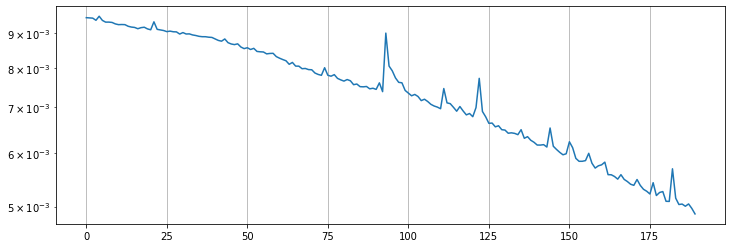

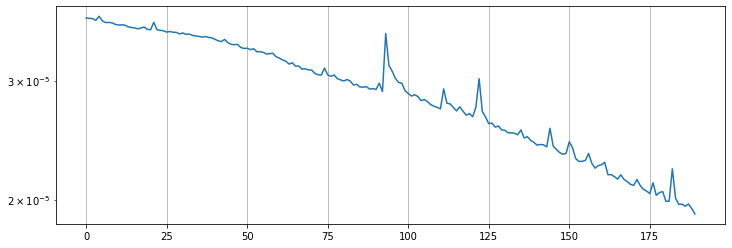

In [22]:
start = 10
_ = plt.figure(figsize=(12,4))
plt.plot(arr_acc_1[start:])
plt.yscale('log')
plt.grid()
plt.show()
_ = plt.figure(figsize=(12,4))
plt.plot(arr_loss_total_1[start:])
plt.yscale('log')
plt.grid()
plt.show()

In [23]:
arr_acc_2, arr_loss_total_2, arr_loss_obs_2 = train(
     pinn,
     optimizer,
     train_acc_metric,
     epochs = 200,
     batch_size = 256,
     print_interval = 10)


Start of epoch 0
Training observations acc over epoch: 0.00485194
total loss: 0.00001899
obs A loss: 0.00000506
obs B loss: 0.00001684
obs C loss: 0.00001154
obs D loss: 0.00002610
obs E loss: 0.00002832
obs F loss: 0.00002608
Time taken: 7.59s

Start of epoch 10
Training observations acc over epoch: 0.00475900
total loss: 0.00001860
obs A loss: 0.00000489
obs B loss: 0.00001633
obs C loss: 0.00001134
obs D loss: 0.00002567
obs E loss: 0.00002772
obs F loss: 0.00002565
Time taken: 73.97s

Start of epoch 20
Training observations acc over epoch: 0.00451065
total loss: 0.00001762
obs A loss: 0.00000483
obs B loss: 0.00001541
obs C loss: 0.00001084
obs D loss: 0.00002428
obs E loss: 0.00002610
obs F loss: 0.00002427
Time taken: 71.96s

Start of epoch 30
Training observations acc over epoch: 0.00427114
total loss: 0.00001668
obs A loss: 0.00000447
obs B loss: 0.00001439
obs C loss: 0.00001048
obs D loss: 0.00002303
obs E loss: 0.00002471
obs F loss: 0.00002302
Time taken: 73.99s

Start of 

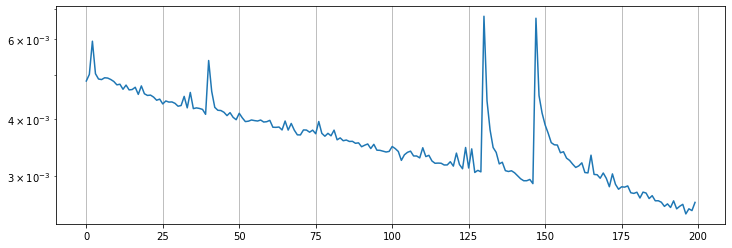

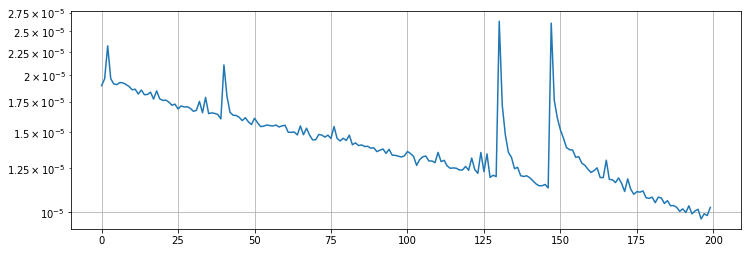

In [24]:
start = 0
_ = plt.figure(figsize=(12,4))
plt.plot(arr_acc_2[start:])
plt.yscale('log')
plt.grid()
plt.show()
_ = plt.figure(figsize=(12,4))
plt.plot(arr_loss_total_2[start:])
plt.yscale('log')
plt.grid()
plt.show()

In [32]:
arr_acc_3, arr_loss_total_3, arr_loss_obs_3 = train(
     pinn,
     optimizer,
     train_acc_metric,
     epochs = 200,
     batch_size = 256,
     print_interval = 10)


Start of epoch 0
Training observations acc over epoch: 0.00251820
total loss: 0.00000984
obs A loss: 0.00000275
obs B loss: 0.00000801
obs C loss: 0.00000684
obs D loss: 0.00001354
obs E loss: 0.00001438
obs F loss: 0.00001353
Time taken: 11.95s

Start of epoch 10
Training observations acc over epoch: 0.00246222
total loss: 0.00000962
obs A loss: 0.00000274
obs B loss: 0.00000782
obs C loss: 0.00000677
obs D loss: 0.00001323
obs E loss: 0.00001396
obs F loss: 0.00001323
Time taken: 120.69s

Start of epoch 20
Training observations acc over epoch: 0.00237250
total loss: 0.00000928
obs A loss: 0.00000262
obs B loss: 0.00000755
obs C loss: 0.00000654
obs D loss: 0.00001276
obs E loss: 0.00001343
obs F loss: 0.00001275
Time taken: 116.19s

Start of epoch 30
Training observations acc over epoch: 0.00228867
total loss: 0.00000894
obs A loss: 0.00000251
obs B loss: 0.00000716
obs C loss: 0.00000631
obs D loss: 0.00001236
obs E loss: 0.00001294
obs F loss: 0.00001235
Time taken: 112.61s

Start

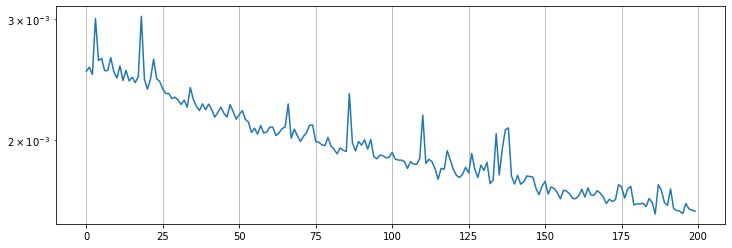

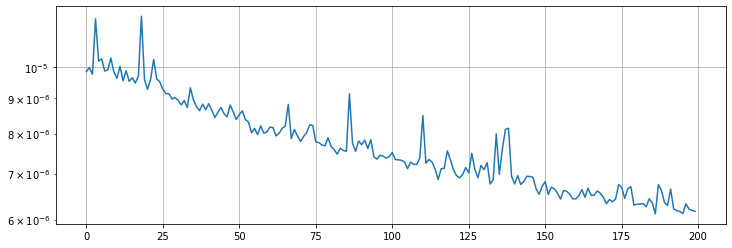

In [40]:
start = 0
_ = plt.figure(figsize=(12,4))
plt.plot(arr_acc_3[start:])
plt.yscale('log')
plt.grid()
plt.show()
_ = plt.figure(figsize=(12,4))
plt.plot(arr_loss_total_3[start:])
plt.yscale('log')
plt.grid()
plt.show()

In [41]:
arr_acc_4, arr_loss_total_4, arr_loss_obs_4 = train(
     pinn,
     optimizer,
     train_acc_metric,
     epochs = 200,
     batch_size = 256,
     print_interval = 10)


Start of epoch 0
Training observations acc over epoch: 0.00159089
total loss: 0.00000621
obs A loss: 0.00000177
obs B loss: 0.00000474
obs C loss: 0.00000433
obs D loss: 0.00000870
obs E loss: 0.00000904
obs F loss: 0.00000870
Time taken: 11.81s

Start of epoch 10
Training observations acc over epoch: 0.00199284
total loss: 0.00000779
obs A loss: 0.00000202
obs B loss: 0.00000610
obs C loss: 0.00000526
obs D loss: 0.00001090
obs E loss: 0.00001155
obs F loss: 0.00001090
Time taken: 114.97s

Start of epoch 20
Training observations acc over epoch: 0.00162906
total loss: 0.00000636
obs A loss: 0.00000180
obs B loss: 0.00000491
obs C loss: 0.00000428
obs D loss: 0.00000895
obs E loss: 0.00000930
obs F loss: 0.00000895
Time taken: 118.18s

Start of epoch 30
Training observations acc over epoch: 0.00153181
total loss: 0.00000598
obs A loss: 0.00000169
obs B loss: 0.00000452
obs C loss: 0.00000410
obs D loss: 0.00000842
obs E loss: 0.00000875
obs F loss: 0.00000842
Time taken: 117.46s

Start

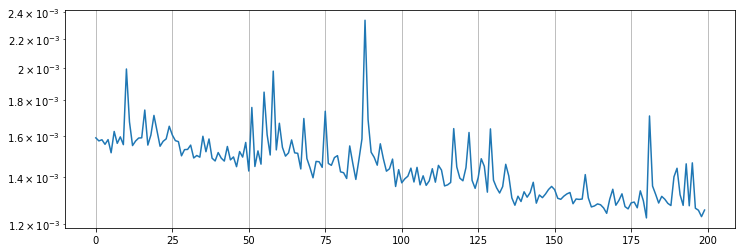

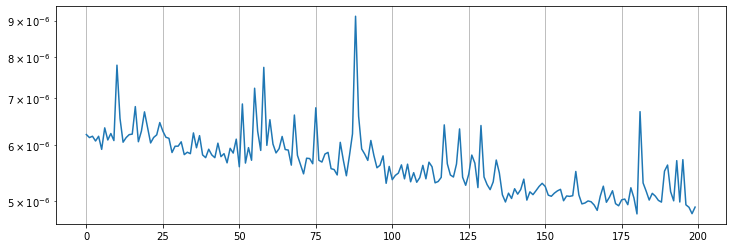

In [42]:
start = 0
_ = plt.figure(figsize=(12,4))
plt.plot(arr_acc_4[start:])
plt.yscale('log')
plt.grid()
plt.show()
_ = plt.figure(figsize=(12,4))
plt.plot(arr_loss_total_4[start:])
plt.yscale('log')
plt.grid()
plt.show()

In [72]:
arr_acc_5, arr_loss_total_5, arr_loss_obs_5 = train(
     pinn,
     optimizer,
     train_acc_metric,
     epochs = 200,
     batch_size = 256,
     print_interval = 5)


Start of epoch 0
Training observations acc over epoch: 0.00126392
total loss: 0.00000497
obs A loss: 0.00000138
obs B loss: 0.00000349
obs C loss: 0.00000334
obs D loss: 0.00000711
obs E loss: 0.00000739
obs F loss: 0.00000710
Time taken: 11.18s

Start of epoch 5
Training observations acc over epoch: 0.00120550
total loss: 0.00000471
obs A loss: 0.00000134
obs B loss: 0.00000328
obs C loss: 0.00000321
obs D loss: 0.00000671
obs E loss: 0.00000700
obs F loss: 0.00000671
Time taken: 56.86s

Start of epoch 10
Training observations acc over epoch: 0.00118579
total loss: 0.00000463
obs A loss: 0.00000133
obs B loss: 0.00000316
obs C loss: 0.00000313
obs D loss: 0.00000660
obs E loss: 0.00000698
obs F loss: 0.00000659
Time taken: 57.19s

Start of epoch 15
Training observations acc over epoch: 0.00123138
total loss: 0.00000481
obs A loss: 0.00000135
obs B loss: 0.00000330
obs C loss: 0.00000322
obs D loss: 0.00000690
obs E loss: 0.00000720
obs F loss: 0.00000689
Time taken: 59.48s

Start of 


Start of epoch 165
Training observations acc over epoch: 0.00107833
total loss: 0.00000421
obs A loss: 0.00000122
obs B loss: 0.00000287
obs C loss: 0.00000277
obs D loss: 0.00000604
obs E loss: 0.00000633
obs F loss: 0.00000604
Time taken: 57.64s

Start of epoch 170
Training observations acc over epoch: 0.00109086
total loss: 0.00000429
obs A loss: 0.00000123
obs B loss: 0.00000295
obs C loss: 0.00000279
obs D loss: 0.00000617
obs E loss: 0.00000640
obs F loss: 0.00000617
Time taken: 58.12s

Start of epoch 175
Training observations acc over epoch: 0.00108943
total loss: 0.00000426
obs A loss: 0.00000124
obs B loss: 0.00000286
obs C loss: 0.00000282
obs D loss: 0.00000616
obs E loss: 0.00000630
obs F loss: 0.00000616
Time taken: 57.59s

Start of epoch 180
Training observations acc over epoch: 0.00112189
total loss: 0.00000438
obs A loss: 0.00000126
obs B loss: 0.00000308
obs C loss: 0.00000295
obs D loss: 0.00000624
obs E loss: 0.00000653
obs F loss: 0.00000624
Time taken: 55.36s

Sta

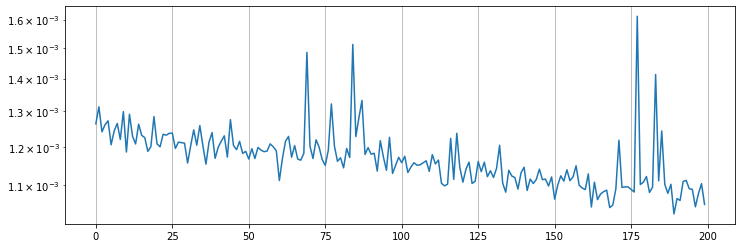

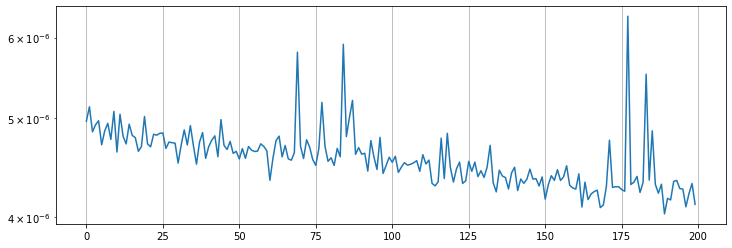

In [73]:
start = 0
_ = plt.figure(figsize=(12,4))
plt.plot(arr_acc_5[start:])
plt.yscale('log')
plt.grid()
plt.show()
_ = plt.figure(figsize=(12,4))
plt.plot(arr_loss_total_5[start:])
plt.yscale('log')
plt.grid()
plt.show()

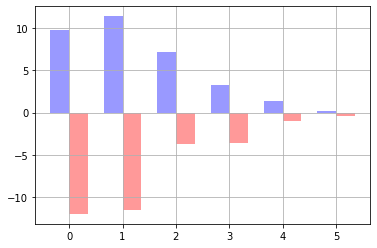

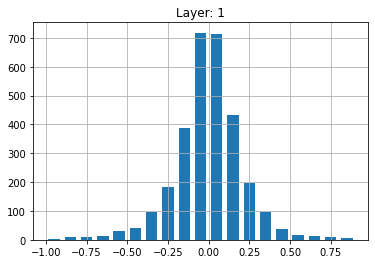

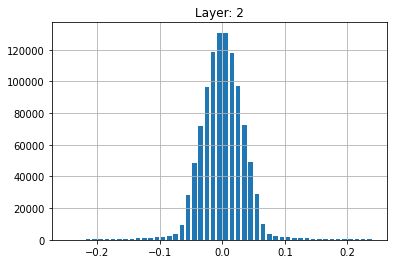

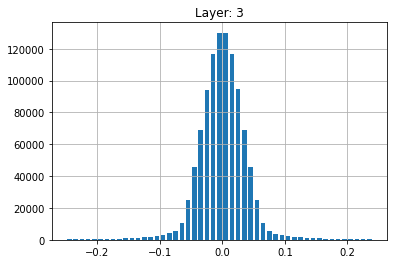

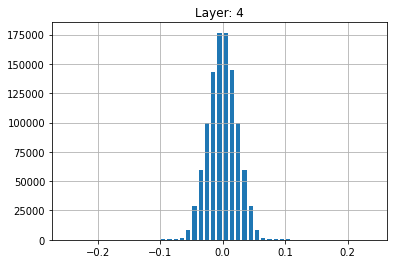

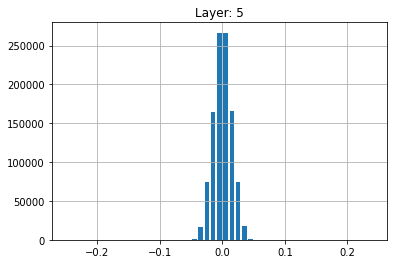

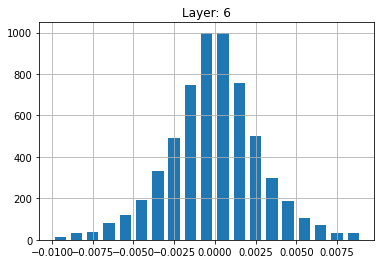

In [76]:
max_ws = np.zeros(len(pinn.Ws))
min_ws = np.zeros(len(pinn.Ws))
for i in range(len(pinn.Ws)):
    max_ws[i] = np.max(pinn.Ws[i].numpy())
    min_ws[i] = np.min(pinn.Ws[i].numpy())
    
index = np.arange(len(pinn.Ws))
bar_width = .35
plt.bar(index , max_ws, bar_width, color='b', alpha = .4)
plt.bar(index + bar_width, min_ws, bar_width, color='r', alpha = .4)

plt.xticks(index + bar_width/2, index)
plt.grid()
plt.show()

#bins = np.zeros((len(pinn.Ws), 50))
#hists = np.zeros((len(pinn.Ws), 49))
for i in range(len(pinn.Ws)):    
    if i == 0:
        bins = np.arange(-1,1,.1)
    elif i >= 1 and i <=4:
        bins = np.arange(-.25,0.25,.01)
    else:
        bins = np.arange(-.01,0.01,.001)
    hists, bins = np.histogram(pinn.Ws[i].numpy(), bins=bins)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.bar(center, hists, align='center', width=width)
    plt.grid()
    plt.title(f"Layer: {i+1}")
    plt.show()
    
# index = np.arange(len(pinn.Ws))
# bar_width = .35
# plt.bar(index , max_ws, bar_width, color='b', alpha = .4)
# plt.bar(index + bar_width, min_ws, bar_width, color='r', alpha = .4)

# plt.xticks(index + bar_width/2, index)
# plt.grid()
# plt.show()

In [77]:
x_domain = L * np.linspace(0, 1, 2*x_size)
y_domain = L * np.linspace(0, 1, 2*y_size)
N2 = 2*x_size * 2*y_size

T_test_index = 0#119
print(t_star[T_test_index])
X_test, Y_test = np.meshgrid(x_domain, y_domain, sparse=False, indexing="ij")
XX_test = X_test.flatten()  # N2 x 1
YY_test = Y_test.flatten()  # N2 x 1
TT_test = np.repeat(t_star[T_test_index], N2)  # 1 x N2

50


In [78]:
output_test = pinn(np.vstack([XX_test, YY_test, TT_test]).T)
output_test = np.array([ output_test[:, i].numpy().reshape((2*x_size, 2*y_size)) for i in range(output_test.shape[1])]) 
#for i in range(output_test.shape[0]):
#    output_test[i, :, :] = (output_test[i, :, :] + 1.0)*(maxs[i]-mins[i])/2.0 + mins[i]

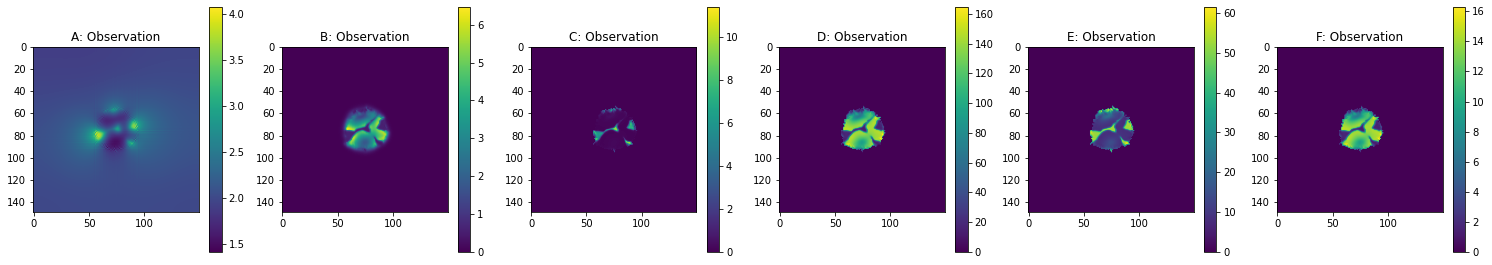

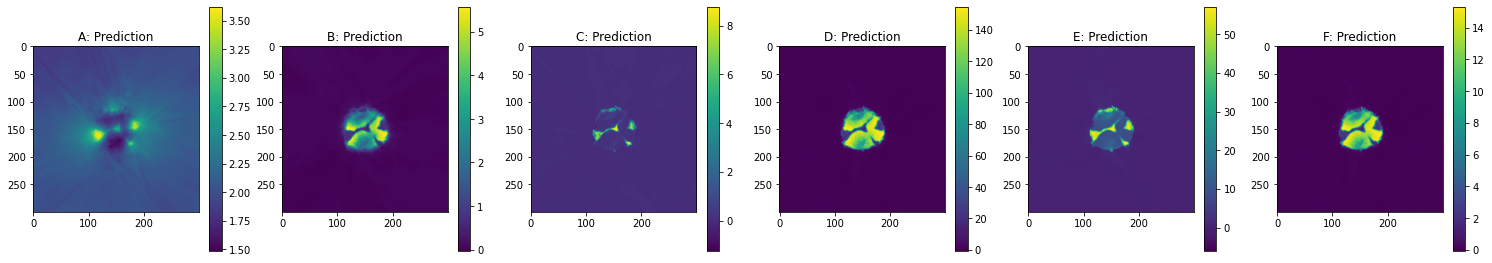

In [79]:
data_original = np.array(ds_1)
_ = plt.figure(figsize=(26,6))
for i, name in enumerate(node_names):
    plt.subplot(1, 6, i+1)
    plt.title(f"{name}: Observation")
    plt.imshow(data_original[i,:, :, t_star[T_test_index]])
    plt.colorbar(shrink=.75)

plt.show()

original_obs_Y = np.float32(dataset['obs_output'])
_ = plt.figure(figsize=(26,6))
for i, name in enumerate(node_names):
    plt.subplot(1, 6, i+1)
    plt.title(f"{name}: Prediction")
    
    y_min = np.min(original_obs_Y[:, i])
    y_max = np.max(original_obs_Y[:, i])
    
    plt.imshow(output_test[i,:, :]*(y_max - y_min) + y_min)
    plt.colorbar(shrink=.75)

plt.show()

In [80]:
x_domain = L * np.linspace(0, 1, x_size)
y_domain = L * np.linspace(0, 1, y_size)
N2 = x_size * y_size

T_test_index = -1#119
print(t_star[T_test_index])
X_test, Y_test = np.meshgrid(x_domain, y_domain, sparse=False, indexing="ij")
XX_test = X_test.flatten()  # N2 x 1
YY_test = Y_test.flatten()  # N2 x 1
TT_test = np.repeat(t_star[T_test_index], N2)  # 1 x N2

118


In [81]:
output_test = pinn(np.vstack([XX_test, YY_test, TT_test]).T)
output_test = np.array([ output_test[:, i].numpy().reshape((x_size, y_size)) for i in range(output_test.shape[1])]) 
#for i in range(output_test.shape[0]):
#    output_test[i, :, :] = (output_test[i, :, :] + 1.0)*(maxs[i]-mins[i])/2.0 + mins[i]

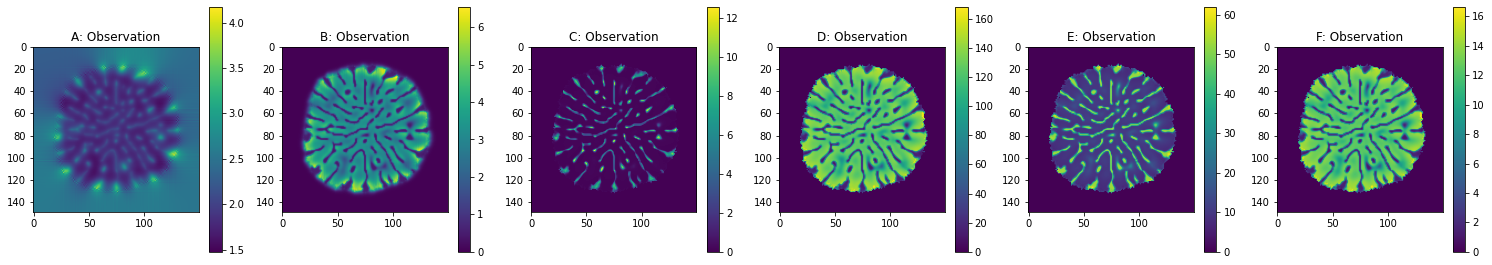

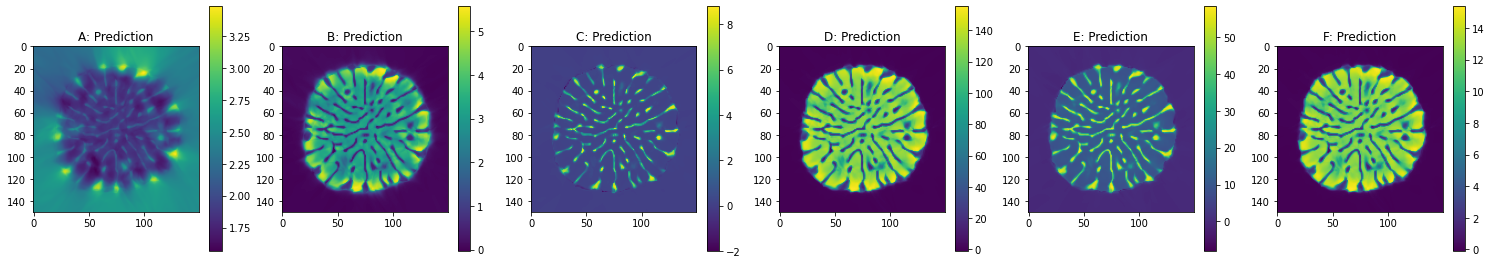

In [82]:
data_original = np.array(ds_1)
_ = plt.figure(figsize=(26,6))
for i, name in enumerate(node_names):
    plt.subplot(1, 6, i+1)
    plt.title(f"{name}: Observation")
    plt.imshow(data_original[i,:, :, t_star[T_test_index]])
    plt.colorbar(shrink=.75)

plt.show()

original_obs_Y = np.float32(dataset['obs_output'])
_ = plt.figure(figsize=(26,6))
for i, name in enumerate(node_names):
    plt.subplot(1, 6, i+1)
    plt.title(f"{name}: Prediction")
    
    y_min = np.min(original_obs_Y[:, i])
    y_max = np.max(original_obs_Y[:, i])
    
    plt.imshow(output_test[i,:, :]*(y_max - y_min) + y_min)
    plt.colorbar(shrink=.75)

plt.show()

# Test Two: Five dense layers that their width decreaes

In [7]:
ID = 194
L = 10
data = np.array(ds_1)
nodes_n = data.shape[0]
node_names = ["A", "B", "C", "D", "E", "F"]
x_size = data.shape[1]
y_size = data.shape[2]
T = data.shape[3]
N = x_size*y_size

t_star = np.arange(0, T)

##########################
# select a subset of data
t_star = t_star[50::4]
T = len(t_star)
data = data[:, :, :, 50::4]

maxs = np.array([np.max(data[i, :, :, :]) for i in range(data.shape[0])])
mins = np.array([np.min(data[i, :, :, :]) for i in range(data.shape[0])])
for i in range(data.shape[0]):
    data[i, :, :, :] = 2.0*(data[i, :, :, :] - mins[i])/(maxs[i]-mins[i]) - 1.0

In [8]:
model_params = {'training_data_size': T*N,#T*32,
                'pde_data_size': T*N}


dataset = create_dataset_multi_nodes_mask(data, mask, t_star, N, T, L, **model_params)
lb = dataset['lb']
ub = dataset['ub']
obs_X = np.float32(dataset['obs_input'])
obs_Y = np.float32(dataset['obs_output'])
pde_X = np.float32(dataset['pde'])
obs_mask = np.float32(dataset['obs_mask'])
pde_mask = dataset['pde_mask'] > 0

#obs_X = obs_X[pde_mask]
#obs_Y = obs_Y[pde_mask]
#pde_X = pde_X[pde_mask]

#pde_mask = np.float32(pde_mask[pde_mask])
# Normalise Ys
# for i in range(obs_Y.shape[1]):
#     y_min = np.min(obs_Y[:, i])
#     y_max = np.max(obs_Y[:, i])
#     obs_Y[:, i] = (obs_Y[:, i] - y_min)/(y_max - y_min) 


In [9]:
layers = [3, 1024, 512, 256, 128, 64, 6]
pinn2 = tu.NN(layers, lb, ub, dtype=tf.float32)

In [10]:
print_interval = 1
shuffle = True
batch_size = 256
x1_size = len(obs_X)
nodes_n = 6
node_names = ["A", "B", "C", "D", "E", "F"]
print_precision = ".8f"

optimizer2=keras.optimizers.Adam(learning_rate=0.01, epsilon=0.01)#keras.optimizers.Nadam()#keras.optimizers.RMSprop()#keras.optimizers.Adam()
train_acc_metric2=keras.metrics.MeanSquaredError()

In [11]:
arr_acc2_1, arr_loss_total2_1, arr_loss_obs2_1 = train(
     pinn2,
     optimizer2,
     train_acc_metric2,
     epochs = 100,
     batch_size = 256,
     print_interval = 1)


Start of epoch 0


2022-07-25 22:38:00.591434: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-07-25 22:38:00.846683: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10


Training observations acc over epoch: 0.10396696
total loss: 0.00040631
obs A loss: 0.00011477
obs B loss: 0.00042535
obs C loss: 0.00009608
obs D loss: 0.00071808
obs E loss: 0.00036227
obs F loss: 0.00072131
Time taken: 7.70s

Start of epoch 1
Training observations acc over epoch: 0.04225311
total loss: 0.00016511
obs A loss: 0.00007960
obs B loss: 0.00014878
obs C loss: 0.00007729
obs D loss: 0.00022903
obs E loss: 0.00022895
obs F loss: 0.00022699
Time taken: 7.05s

Start of epoch 2
Training observations acc over epoch: 0.03878469
total loss: 0.00015153
obs A loss: 0.00007404
obs B loss: 0.00013285
obs C loss: 0.00007551
obs D loss: 0.00020452
obs E loss: 0.00022022
obs F loss: 0.00020203
Time taken: 7.26s

Start of epoch 3
Training observations acc over epoch: 0.03771826
total loss: 0.00014750
obs A loss: 0.00006843
obs B loss: 0.00012969
obs C loss: 0.00007407
obs D loss: 0.00019922
obs E loss: 0.00021553
obs F loss: 0.00019804
Time taken: 6.31s

Start of epoch 4
Training observa

Training observations acc over epoch: 0.01793829
total loss: 0.00007011
obs A loss: 0.00001331
obs B loss: 0.00005934
obs C loss: 0.00004489
obs D loss: 0.00009777
obs E loss: 0.00010767
obs F loss: 0.00009770
Time taken: 5.72s

Start of epoch 35
Training observations acc over epoch: 0.01831393
total loss: 0.00007159
obs A loss: 0.00001404
obs B loss: 0.00006100
obs C loss: 0.00004554
obs D loss: 0.00009964
obs E loss: 0.00010978
obs F loss: 0.00009956
Time taken: 6.57s

Start of epoch 36
Training observations acc over epoch: 0.01717073
total loss: 0.00006708
obs A loss: 0.00001315
obs B loss: 0.00005656
obs C loss: 0.00004338
obs D loss: 0.00009330
obs E loss: 0.00010288
obs F loss: 0.00009323
Time taken: 6.65s

Start of epoch 37
Training observations acc over epoch: 0.01617958
total loss: 0.00006323
obs A loss: 0.00001247
obs B loss: 0.00005274
obs C loss: 0.00004186
obs D loss: 0.00008783
obs E loss: 0.00009673
obs F loss: 0.00008777
Time taken: 6.10s

Start of epoch 38
Training obs

Training observations acc over epoch: 0.00946051
total loss: 0.00003696
obs A loss: 0.00000843
obs B loss: 0.00002876
obs C loss: 0.00002927
obs D loss: 0.00005052
obs E loss: 0.00005429
obs F loss: 0.00005049
Time taken: 7.08s

Start of epoch 69
Training observations acc over epoch: 0.00932744
total loss: 0.00003645
obs A loss: 0.00000837
obs B loss: 0.00002836
obs C loss: 0.00002915
obs D loss: 0.00004969
obs E loss: 0.00005349
obs F loss: 0.00004966
Time taken: 7.17s

Start of epoch 70
Training observations acc over epoch: 0.00913830
total loss: 0.00003570
obs A loss: 0.00000837
obs B loss: 0.00002783
obs C loss: 0.00002875
obs D loss: 0.00004855
obs E loss: 0.00005217
obs F loss: 0.00004852
Time taken: 7.64s

Start of epoch 71
Training observations acc over epoch: 0.00906555
total loss: 0.00003542
obs A loss: 0.00000825
obs B loss: 0.00002745
obs C loss: 0.00002862
obs D loss: 0.00004817
obs E loss: 0.00005186
obs F loss: 0.00004815
Time taken: 7.73s

Start of epoch 72
Training obs

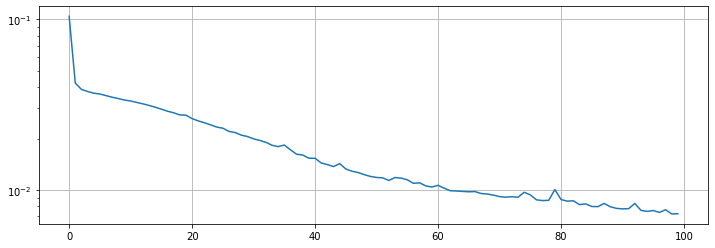

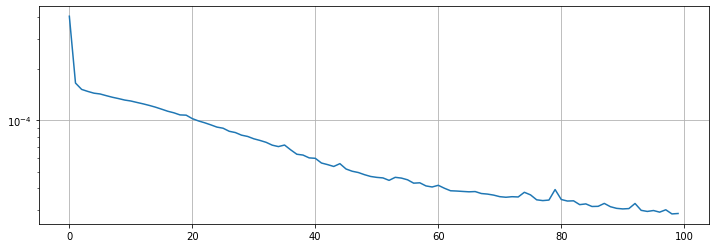

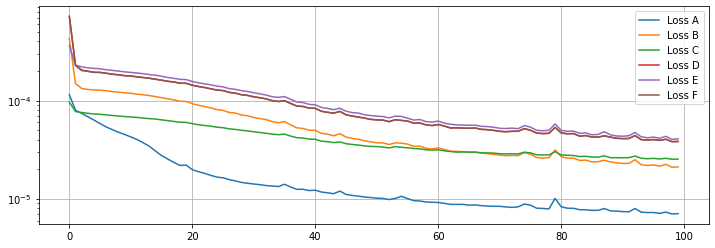

In [56]:
start = 0
_ = plt.figure(figsize=(12,4))
plt.plot(arr_acc2_1[start:])
plt.yscale('log')
plt.grid()
plt.show()
_ = plt.figure(figsize=(12,4))
plt.plot(arr_loss_total2_1[start:])
plt.yscale('log')
plt.grid()
plt.show()

_ = plt.figure(figsize=(12,4))
for i, name in enumerate(node_names):
    plt.plot(arr_loss_obs2_1[start:, i], label=f"Loss {name}")
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()

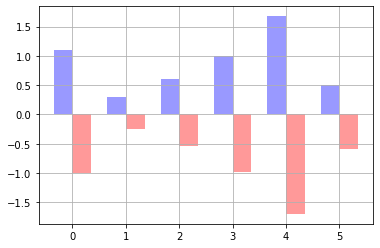

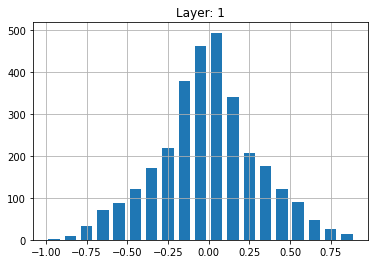

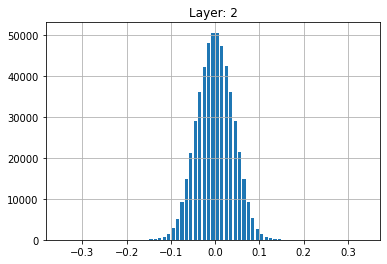

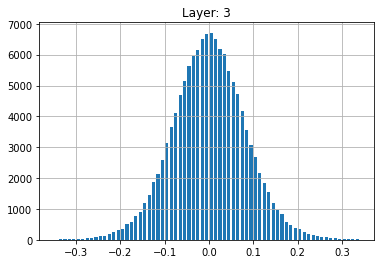

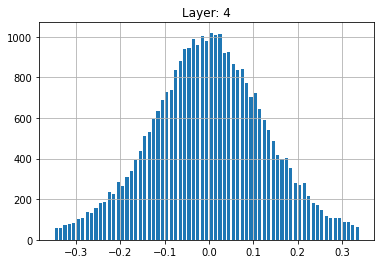

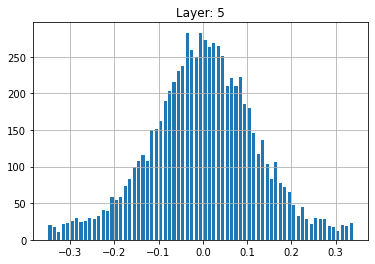

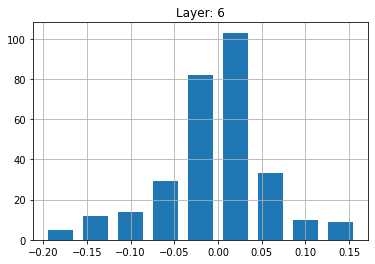

In [16]:
max_ws = np.zeros(len(pinn2.Ws))
min_ws = np.zeros(len(pinn2.Ws))
for i in range(len(pinn2.Ws)):
    max_ws[i] = np.max(pinn2.Ws[i].numpy())
    min_ws[i] = np.min(pinn2.Ws[i].numpy())
    
index = np.arange(len(pinn2.Ws))
bar_width = .35
plt.bar(index , max_ws, bar_width, color='b', alpha = .4)
plt.bar(index + bar_width, min_ws, bar_width, color='r', alpha = .4)

plt.xticks(index + bar_width/2, index)
plt.grid()
plt.show()

#bins = np.zeros((len(pinn.Ws), 50))
#hists = np.zeros((len(pinn.Ws), 49))
for i in range(len(pinn2.Ws)):    
    if i == 0:
        bins = np.arange(-1,1,.1)
    elif i >= 1 and i <=4:
        bins = np.arange(-.35,0.35,.01)
    else:
        bins = np.arange(-.2,0.2,.04)
    hists, bins = np.histogram(pinn2.Ws[i].numpy(), bins=bins)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.bar(center, hists, align='center', width=width)
    plt.grid()
    plt.title(f"Layer: {i+1}")
    plt.show()


In [17]:
x_domain = L * np.linspace(0, 1, 2*x_size)
y_domain = L * np.linspace(0, 1, 2*y_size)
N2 = 2*x_size * 2*y_size

T_test_index = 0#119
print(t_star[T_test_index])
X_test, Y_test = np.meshgrid(x_domain, y_domain, sparse=False, indexing="ij")
XX_test = X_test.flatten()  # N2 x 1
YY_test = Y_test.flatten()  # N2 x 1
TT_test = np.repeat(t_star[T_test_index], N2)  # 1 x N2

output_test = pinn2(np.vstack([XX_test, YY_test, TT_test]).T)
output_test = np.array([ output_test[:, i].numpy().reshape((2*x_size, 2*y_size)) for i in range(output_test.shape[1])]) 


50


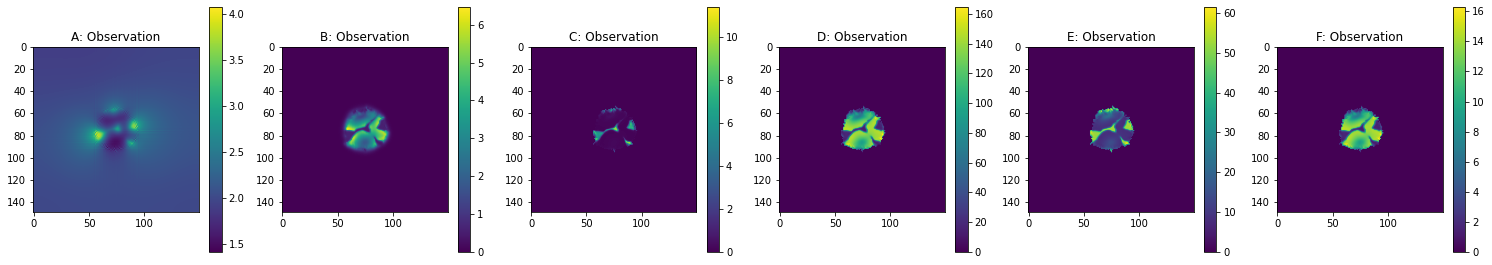

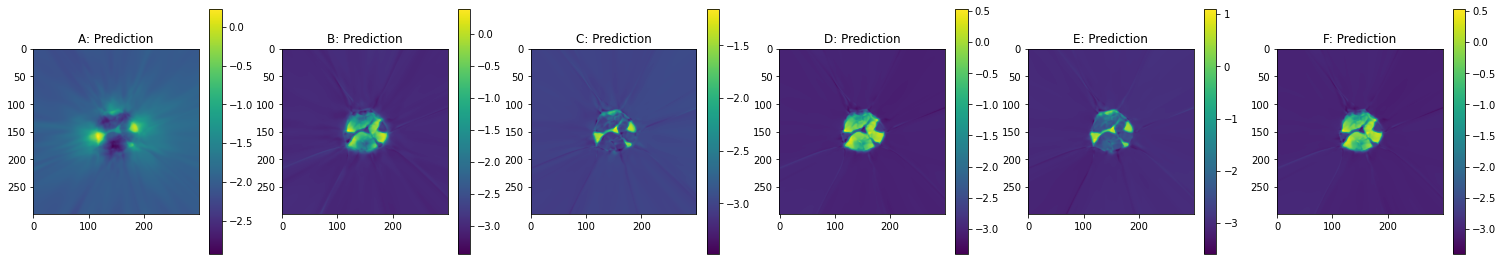

In [18]:
data_original = np.array(ds_1)
_ = plt.figure(figsize=(26,6))
for i, name in enumerate(node_names):
    plt.subplot(1, 6, i+1)
    plt.title(f"{name}: Observation")
    plt.imshow(data_original[i,:, :, t_star[T_test_index]])
    plt.colorbar(shrink=.75)

plt.show()

original_obs_Y = np.float32(dataset['obs_output'])
_ = plt.figure(figsize=(26,6))
for i, name in enumerate(node_names):
    plt.subplot(1, 6, i+1)
    plt.title(f"{name}: Prediction")
    
    y_min = np.min(original_obs_Y[:, i])
    y_max = np.max(original_obs_Y[:, i])
    
    plt.imshow(output_test[i,:, :]*(y_max - y_min) + y_min)
    plt.colorbar(shrink=.75)

plt.show()

In [19]:
x_domain = L * np.linspace(0, 1, x_size)
y_domain = L * np.linspace(0, 1, y_size)
N2 = x_size * y_size

T_test_index = -1#119
print(t_star[T_test_index])
X_test, Y_test = np.meshgrid(x_domain, y_domain, sparse=False, indexing="ij")
XX_test = X_test.flatten()  # N2 x 1
YY_test = Y_test.flatten()  # N2 x 1
TT_test = np.repeat(t_star[T_test_index], N2)  # 1 x N2

output_test = pinn2(np.vstack([XX_test, YY_test, TT_test]).T)
output_test = np.array([ output_test[:, i].numpy().reshape((x_size, y_size)) for i in range(output_test.shape[1])]) 


118


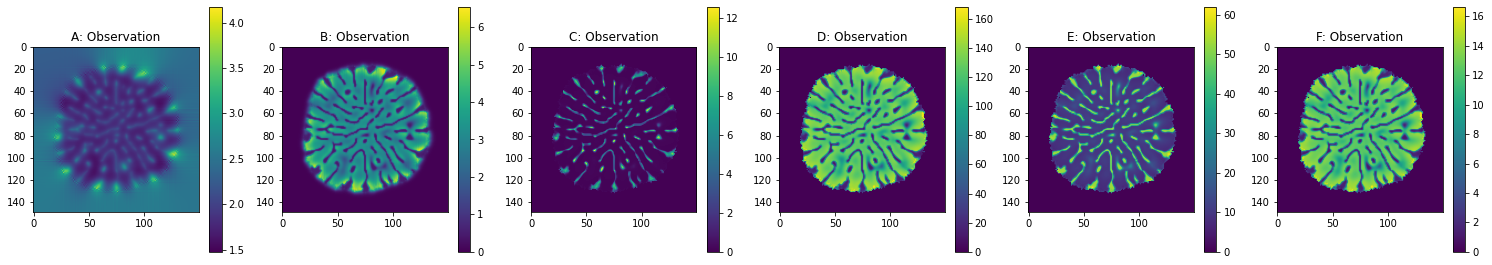

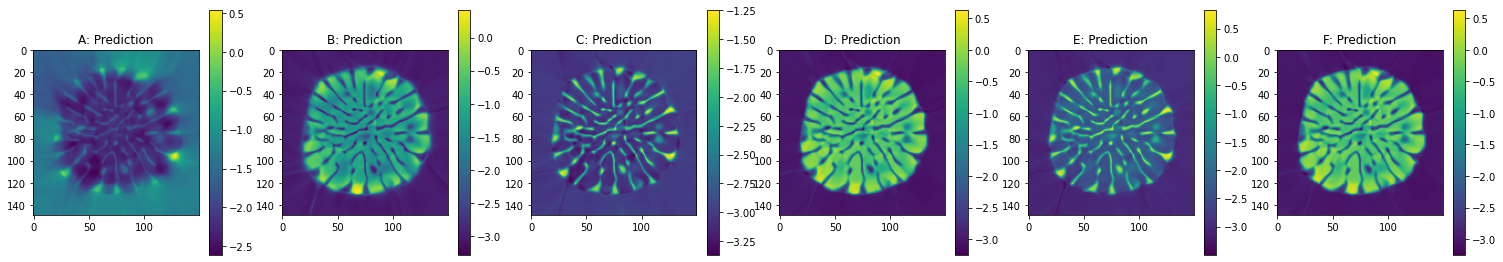

In [20]:
data_original = np.array(ds_1)
_ = plt.figure(figsize=(26,6))
for i, name in enumerate(node_names):
    plt.subplot(1, 6, i+1)
    plt.title(f"{name}: Observation")
    plt.imshow(data_original[i,:, :, t_star[T_test_index]])
    plt.colorbar(shrink=.75)

plt.show()

original_obs_Y = np.float32(dataset['obs_output'])
_ = plt.figure(figsize=(26,6))
for i, name in enumerate(node_names):
    plt.subplot(1, 6, i+1)
    plt.title(f"{name}: Prediction")
    
    y_min = np.min(original_obs_Y[:, i])
    y_max = np.max(original_obs_Y[:, i])
    
    plt.imshow(output_test[i,:, :]*(y_max - y_min) + y_min)
    plt.colorbar(shrink=.75)

plt.show()

# Test three: PDE only, decreasing width

In [109]:
model_params = {'training_data_size': T*N,#T*32,
                'pde_data_size': T*N}


dataset = create_dataset_multi_nodes_mask(data, mask, t_star, N, T, L, **model_params)
lb = dataset['lb']
ub = dataset['ub']
obs_X = np.float32(dataset['obs_input'])
obs_Y = np.float32(dataset['obs_output'])
pde_X = np.float32(dataset['pde'])
obs_mask = np.float32(dataset['obs_mask'])
#pde_mask = dataset['pde_mask'] > 0
#pde_X = pde_X[pde_mask]
#pde_mask = np.float32(pde_mask[pde_mask])

# for i in range(obs_Y.shape[1]):
#     y_min = np.min(obs_Y[:, i])
#     y_max = np.max(obs_Y[:, i])
#     obs_Y[:, i] = (obs_Y[:, i] - y_min)/(y_max - y_min) 


In [110]:
#layers = [3, 1024, 512, 256, 128, 64, 6]
layers = [3, 1024, 512, 256, 128, 64, 6]
pinn3 = tu.NN(layers, lb, ub, dtype=tf.float32)

In [111]:
print_interval = 1
shuffle = True
batch_size = 256
x1_size = len(pde_X)
nodes_n = 6
node_names = ["A", "B", "C", "D", "E", "F"]
print_precision = ".8f"

optimizer3=keras.optimizers.Adam(learning_rate=0.01)#keras.optimizers.Nadam()#keras.optimizers.RMSprop()#keras.optimizers.Adam()

In [112]:
@tf.function
def train_step_pde(pinn, x_pde,  optimizer):
    with tf.GradientTape(persistent=False) as tape:        
        outputs = pinn(x_pde)
        p1 = [tf.gradients(outputs[:, i], x_pde)[0] for i in range(outputs.shape[1])]
        p2 = [tf.gradients(p1[i], x_pde)[0] for i in range(outputs.shape[1])]
        
        A = outputs[:, 0]
        B = outputs[:, 1]
        C = outputs[:, 2]
        D = outputs[:, 3]
        E = outputs[:, 4]
        F = outputs[:, 5]
        
        A_t = tf.cast(p1[0][:, 2], pinn.dtype)
        A_xx = tf.cast(p2[0][:, 0], pinn.dtype)
        A_yy = tf.cast(p2[0][:, 1], pinn.dtype)
        
        B_t = tf.cast(p1[1][:, 2], pinn.dtype)
        B_xx = tf.cast(p2[1][:, 0], pinn.dtype)
        B_yy = tf.cast(p2[1][:, 1], pinn.dtype)
        
        C_t = tf.cast(p1[2][:, 2], pinn.dtype)
        D_t = tf.cast(p1[3][:, 2], pinn.dtype)
        E_t = tf.cast(p1[4][:, 2], pinn.dtype)
        F_t = tf.cast(p1[5][:, 2], pinn.dtype)
        
        def noncompetitiveact(U, km, n=2):
            act = ((U / (km + 1e-20)) ** (n)) / (1 + (U / (km + 1e-20)) ** (n))
            return act

        def noncompetitiveinh(U, km, n=2):
            inh = 1 / (1 + (U / (km + 1e-20)) ** (n))
            return inh
        
        D_A=df_params.d_A[ID]
        D_B=df_params.d_B[ID]
        b_A=df_params.ba[ID]
        b_B=df_params.bb[ID]
        b_C=df_params.bc[ID]
        b_D=df_params.bd[ID]
        b_E=df_params.be[ID]
        b_F=df_params.bf[ID]
        V_A=df_params.Va[ID]
        V_B=df_params.Vb[ID]
        V_C=df_params.Vc[ID]
        V_D=df_params.Vd[ID]
        V_E=df_params.Ve[ID]
        V_F=df_params.Vf[ID]
        k_AA=df_params.kaa[ID]
        k_BD=df_params.kbd[ID]
        k_CE=df_params.kce[ID]
        k_DA=df_params.kda[ID]
        k_EB=df_params.keb[ID]
        k_EE=df_params.kee[ID]
        k_FE=df_params.kfe[ID]
        mu_A=df_params.mua[ID]
        mulv_A=df_params.mulva[ID]

        f_A = A_t - D_A * (A_xx + A_yy) - b_A - V_A * noncompetitiveinh(D, k_DA) + mu_A * A
        f_B = (
            B_t
            - D_B * (B_xx + B_yy)
            - b_B
            - V_B * noncompetitiveact(A, k_AA) * noncompetitiveinh(E, k_EB)
            + mu_A * B
        )
        f_C = C_t - b_C - V_C * noncompetitiveinh(D, k_DA) + mulv_A * C
        f_D = D_t - b_D - V_D * noncompetitiveact(B, k_BD) + mulv_A * D
        f_E = (
            E_t
            - b_E
            - V_E
            * noncompetitiveinh(C, k_CE)
            * noncompetitiveinh(F, k_FE)
            * noncompetitiveact(E, k_EE)
            + mulv_A * E
        )
        f_F = F_t - b_F - V_F * noncompetitiveact(B, k_BD) + mulv_A * F
        
        f_pde = tf.stack([f_A, f_B, f_C, f_D, f_E, f_F])
        loss_pde = tf.reduce_mean(tf.square(f_pde), axis=1)        
        loss_val = tf.reduce_mean(loss_pde)

    grads = tape.gradient(loss_val, pinn.trainable_variables)
    optimizer.apply_gradients(zip(grads, pinn.trainable_variables))    
    return loss_val, loss_pde

def train_pde(pinn, optimizer, epochs, batch_size, print_interval):
    arr_loss_total = np.zeros(epochs)
    arr_loss_pde = np.zeros((epochs, nodes_n))

    start_time = time.time()
    for epoch in range(epochs):        
        if epoch % print_interval == 0:            
            print(f"\nStart of epoch {epoch:d}")

        loss_total, loss_pde = 0, np.zeros(nodes_n)
        # Iterate over the batches of the dataset.
        for step, p_batch_indices in enumerate(indices(batch_size, shuffle, x1_size)):            
            x_batch_pde = pde_X[p_batch_indices]
            #domain_mask_pde = pde_mask[p_batch_indices]
            loss_value_batch, loss_pde_batch = train_step_pde(pinn,
                x_batch_pde,
                #domain_mask_pde,
                optimizer
            )
            w_obs = len(p_batch_indices) / x1_size
            loss_total += loss_value_batch * w_obs
            loss_pde += [item.numpy() * w_obs for item in loss_pde_batch]

        # end of for step, o_batch_indices in enumerate(indice(batch_size, shuffle, X_size))
        arr_loss_total[epoch] = loss_total
        arr_loss_pde[epoch, :] = loss_pde
        if epoch % print_interval == 0:
            print(f"total loss: {loss_total:{print_precision}}")
            for i, name in enumerate(node_names):
                print(f"obs {name} loss: {loss_pde[i]:{print_precision}}")

        if epoch % print_interval == 0:
            print(f"Time taken: {(time.time() - start_time):.2f}s")
            start_time = time.time()
            
    return  arr_loss_total, arr_loss_pde

In [113]:
arr_loss_total3_1, arr_loss_obs3_1 = train_pde(
     pinn3,
     optimizer3,
     epochs = 100,
     batch_size = 256,
     print_interval = 1)


Start of epoch 0
total loss: 0.63778520
obs A loss: 1.70895048
obs B loss: 0.27169658
obs C loss: 0.02672394
obs D loss: 1.39911061
obs E loss: 0.19871113
obs F loss: 0.22151234
Time taken: 18.92s

Start of epoch 1
total loss: 0.00717168
obs A loss: 0.00000526
obs B loss: 0.04037490
obs C loss: 0.00015260
obs D loss: 0.00177582
obs E loss: 0.00035788
obs F loss: 0.00036356
Time taken: 15.64s

Start of epoch 2
total loss: 0.00388441
obs A loss: 0.00000158
obs B loss: 0.01623724
obs C loss: 0.00003182
obs D loss: 0.00610202
obs E loss: 0.00013849
obs F loss: 0.00079527
Time taken: 16.34s

Start of epoch 3
total loss: 0.00268509
obs A loss: 0.00000219
obs B loss: 0.00746227
obs C loss: 0.00000658
obs D loss: 0.00746000
obs E loss: 0.00007394
obs F loss: 0.00110555
Time taken: 16.15s

Start of epoch 4
total loss: 0.00215974
obs A loss: 0.00000686
obs B loss: 0.00342379
obs C loss: 0.00000215
obs D loss: 0.00831338
obs E loss: 0.00009246
obs F loss: 0.00111981
Time taken: 16.12s

Start of 

total loss: 0.00152100
obs A loss: 0.00002965
obs B loss: 0.00003047
obs C loss: 0.00000271
obs D loss: 0.00882172
obs E loss: 0.00012673
obs F loss: 0.00011476
Time taken: 15.50s

Start of epoch 43
total loss: 0.00146118
obs A loss: 0.00002849
obs B loss: 0.00002933
obs C loss: 0.00000261
obs D loss: 0.00847457
obs E loss: 0.00012177
obs F loss: 0.00011030
Time taken: 16.18s

Start of epoch 44
total loss: 0.00145678
obs A loss: 0.00002843
obs B loss: 0.00002925
obs C loss: 0.00000260
obs D loss: 0.00844884
obs E loss: 0.00012156
obs F loss: 0.00010999
Time taken: 16.09s

Start of epoch 45
total loss: 0.00151572
obs A loss: 0.00002956
obs B loss: 0.00003038
obs C loss: 0.00000271
obs D loss: 0.00879097
obs E loss: 0.00012634
obs F loss: 0.00011437
Time taken: 16.26s

Start of epoch 46
total loss: 0.00148800
obs A loss: 0.00002902
obs B loss: 0.00002979
obs C loss: 0.00000266
obs D loss: 0.00863010
obs E loss: 0.00012413
obs F loss: 0.00011230
Time taken: 16.32s

Start of epoch 47
total

total loss: 0.00150808
obs A loss: 0.00002943
obs B loss: 0.00003022
obs C loss: 0.00000269
obs D loss: 0.00874650
obs E loss: 0.00012581
obs F loss: 0.00011381
Time taken: 15.41s

Start of epoch 85
total loss: 0.00143630
obs A loss: 0.00002801
obs B loss: 0.00002886
obs C loss: 0.00000256
obs D loss: 0.00833023
obs E loss: 0.00011972
obs F loss: 0.00010844
Time taken: 15.92s

Start of epoch 86
total loss: 0.00154535
obs A loss: 0.00003019
obs B loss: 0.00003090
obs C loss: 0.00000277
obs D loss: 0.00896250
obs E loss: 0.00012916
obs F loss: 0.00011660
Time taken: 15.56s

Start of epoch 87
total loss: 0.00137668
obs A loss: 0.00002683
obs B loss: 0.00002777
obs C loss: 0.00000245
obs D loss: 0.00798444
obs E loss: 0.00011457
obs F loss: 0.00010399
Time taken: 15.49s

Start of epoch 88
total loss: 0.00146878
obs A loss: 0.00002864
obs B loss: 0.00002942
obs C loss: 0.00000262
obs D loss: 0.00851871
obs E loss: 0.00012242
obs F loss: 0.00011085
Time taken: 15.32s

Start of epoch 89
total

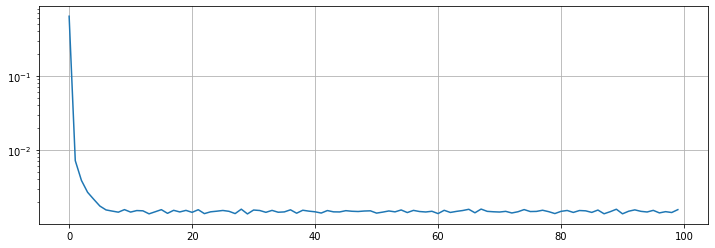

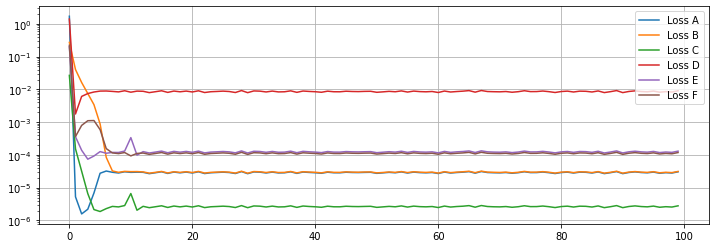

In [114]:
start = 0
_ = plt.figure(figsize=(12,4))
plt.plot(arr_loss_total3_1[start:])
plt.yscale('log')
plt.grid()
plt.show()
_ = plt.figure(figsize=(12,4))
for i, name in enumerate(node_names):
    plt.plot(arr_loss_obs3_1[start:, i], label=f"Loss {name}")
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()

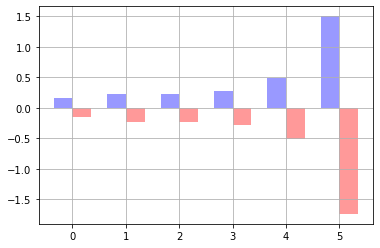

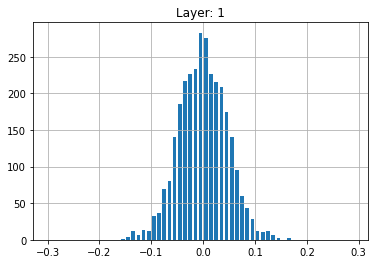

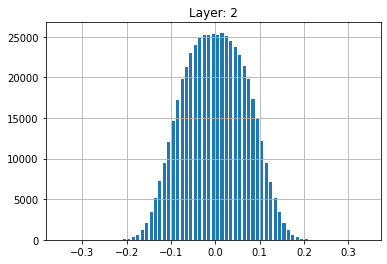

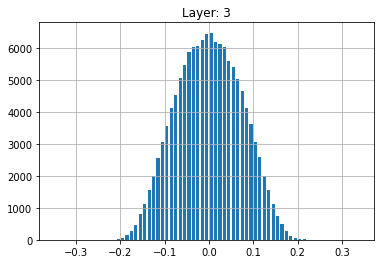

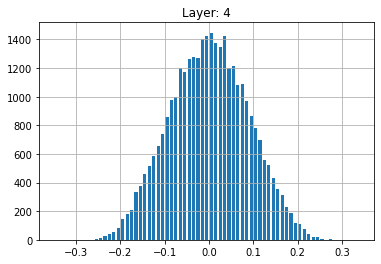

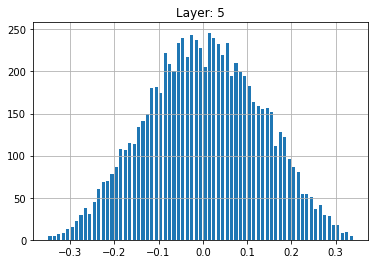

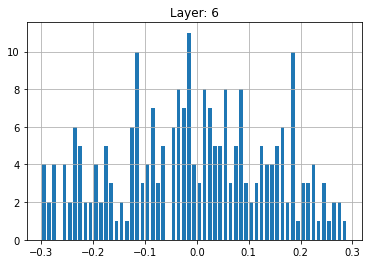

In [115]:
max_ws = np.zeros(len(pinn3.Ws))
min_ws = np.zeros(len(pinn3.Ws))
for i in range(len(pinn3.Ws)):
    max_ws[i] = np.max(pinn3.Ws[i].numpy())
    min_ws[i] = np.min(pinn3.Ws[i].numpy())
    
index = np.arange(len(pinn3.Ws))
bar_width = .35
plt.bar(index , max_ws, bar_width, color='b', alpha = .4)
plt.bar(index + bar_width, min_ws, bar_width, color='r', alpha = .4)

plt.xticks(index + bar_width/2, index)
plt.grid()
plt.show()

#bins = np.zeros((len(pinn.Ws), 50))
#hists = np.zeros((len(pinn.Ws), 49))
for i in range(len(pinn3.Ws)):    
    if i == 0:
        bins = np.arange(-.3,.3,.01)
    elif i >= 1 and i <=4:
        bins = np.arange(-.35,0.35,.01)
    else:
        bins = np.arange(-.3,0.3,.01)
    hists, bins = np.histogram(pinn3.Ws[i].numpy(), bins=bins)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.bar(center, hists, align='center', width=width)
    plt.grid()
    plt.title(f"Layer: {i+1}")
    plt.show()


In [116]:
x_domain = L * np.linspace(0, 1, 2*x_size)
y_domain = L * np.linspace(0, 1, 2*y_size)
N2 = 2*x_size * 2*y_size

T_test_index = 0#119
print(t_star[T_test_index])
X_test, Y_test = np.meshgrid(x_domain, y_domain, sparse=False, indexing="ij")
XX_test = X_test.flatten()  # N2 x 1
YY_test = Y_test.flatten()  # N2 x 1
TT_test = np.repeat(t_star[T_test_index], N2)  # 1 x N2

output_test = pinn3(np.vstack([XX_test, YY_test, TT_test]).T)
output_test = np.array([ output_test[:, i].numpy().reshape((2*x_size, 2*y_size)) for i in range(output_test.shape[1])]) 


50


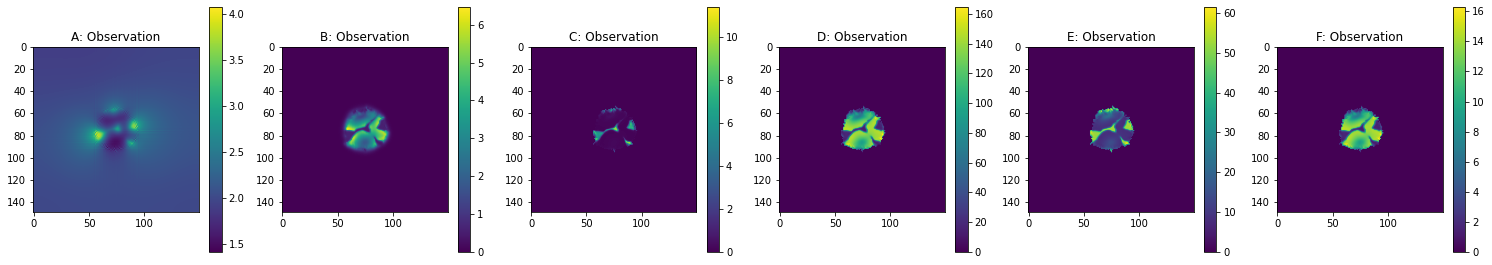

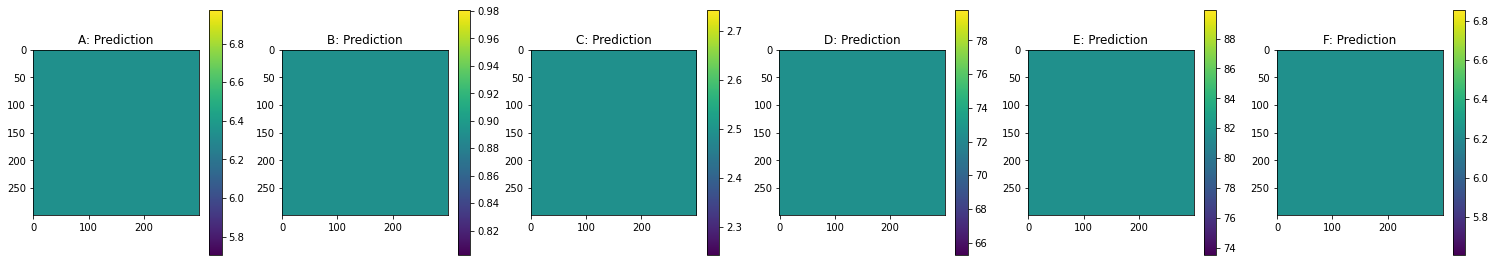

In [117]:
data_original = np.array(ds_1)
_ = plt.figure(figsize=(26,6))
for i, name in enumerate(node_names):
    plt.subplot(1, 6, i+1)
    plt.title(f"{name}: Observation")
    plt.imshow(data_original[i,:, :, t_star[T_test_index]])
    plt.colorbar(shrink=.75)

plt.show()

original_obs_Y = np.float32(dataset['obs_output'])
_ = plt.figure(figsize=(26,6))
for i, name in enumerate(node_names):
    plt.subplot(1, 6, i+1)
    plt.title(f"{name}: Prediction")
    
    y_min = np.min(original_obs_Y[:, i])
    y_max = np.max(original_obs_Y[:, i])
    
    plt.imshow(output_test[i,:, :]*(y_max - y_min) + y_min)
    plt.colorbar(shrink=.75)

plt.show()

In [118]:
x_domain = L * np.linspace(0, 1, x_size)
y_domain = L * np.linspace(0, 1, y_size)
N2 = x_size * y_size

T_test_index = -1#119
print(t_star[T_test_index])
X_test, Y_test = np.meshgrid(x_domain, y_domain, sparse=False, indexing="ij")
XX_test = X_test.flatten()  # N2 x 1
YY_test = Y_test.flatten()  # N2 x 1
TT_test = np.repeat(t_star[T_test_index], N2)  # 1 x N2

output_test = pinn3(np.vstack([XX_test, YY_test, TT_test]).T)
output_test = np.array([ output_test[:, i].numpy().reshape((x_size, y_size)) for i in range(output_test.shape[1])]) 


118


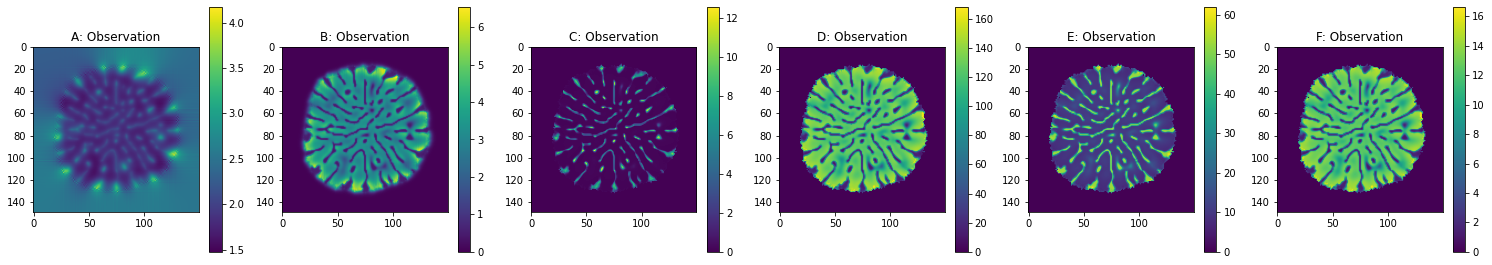

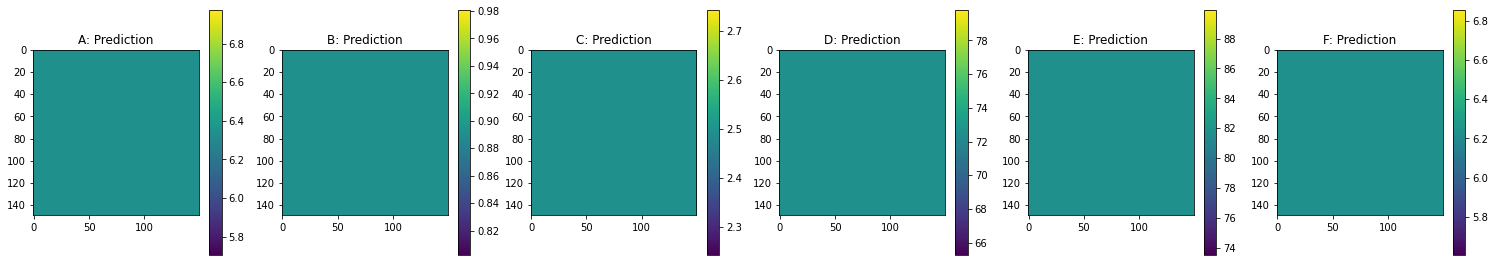

In [119]:
data_original = np.array(ds_1)
_ = plt.figure(figsize=(26,6))
for i, name in enumerate(node_names):
    plt.subplot(1, 6, i+1)
    plt.title(f"{name}: Observation")
    plt.imshow(data_original[i,:, :, t_star[T_test_index]])
    plt.colorbar(shrink=.75)

plt.show()

original_obs_Y = np.float32(dataset['obs_output'])
_ = plt.figure(figsize=(26,6))
for i, name in enumerate(node_names):
    plt.subplot(1, 6, i+1)
    plt.title(f"{name}: Prediction")
    
    y_min = np.min(original_obs_Y[:, i])
    y_max = np.max(original_obs_Y[:, i])
    
    plt.imshow(output_test[i,:, :]*(y_max - y_min) + y_min)
    plt.colorbar(shrink=.75)

plt.show()